In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

/tmp/ipykernel_31276/1056814220.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_31276/1056814220.py:25: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana_f", cmap)


## data female

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_female = pd.concat([sample,sample2])
df_female.rename(columns={'binned_age': 'age'}, inplace=True)

df_female.set_index(['age', 'mouse'], inplace=True)


## data males

In [6]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

## normalized

In [7]:
# avarage per age or session
f_df= df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

## pca females

In [8]:
## female
df=f_norm.copy()
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [9]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')
age_pc = pcs.drop('mouse', axis=1).groupby('age').mean()

In [10]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.21944791 0.36907736 0.46505462]


In [11]:
# Create a colormap
#colors = plt.cm.cmf(np.linspace(0, 1, len(pcs)))
from matplotlib.collections import LineCollection
# Create segments for LineCollection
points = np.array([age_pc['PC1'],age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1))
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))

Text(0, 0.5, 'PC2')

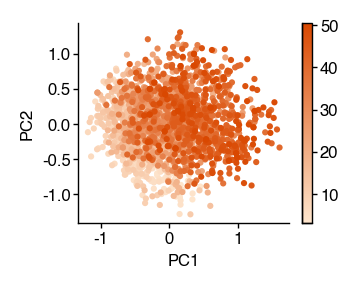

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(1.7,1.3) 
im = ax.scatter(x=pcs['PC1'], y=pcs['PC2'], 
                cmap=cmf,
                s=5,
                edgecolor='none',
                c=pcs['age'], 
               )
cb=fig.colorbar(im,ax=ax)
tick_values = [10,20,30,40,50]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])

sns.despine()
#plt.title('female ontogeny')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [13]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_female_norm_longv2.pdf')

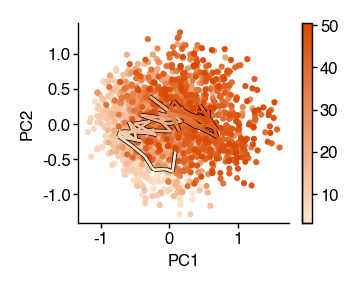

In [14]:
# Create segments for LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=1.5)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=5,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])


# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_female_norm_line_longv2.pdf')

0.6090942545309023


/tmp/ipykernel_31276/3081701080.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


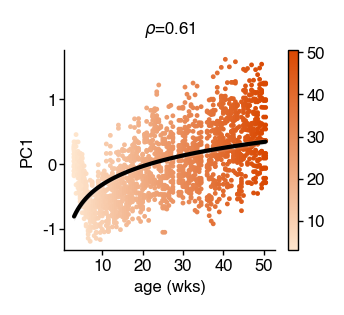

In [16]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)
fig, ax = plt.subplots()
fig.set_size_inches(1.7,1.3) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=3, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmf)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC1', xticks=[10,20,30,40,50])
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_pc1_correlation_female_longv2.pdf')

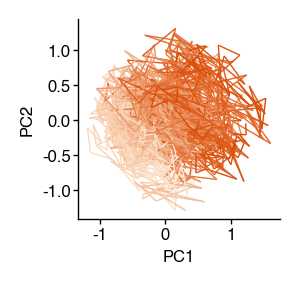

In [18]:
# Create a color map for the mice
import random
mice = pcs['mouse'].unique()
colors = sns.color_palette('husl', len(mice))
color_map = dict(zip(mice, colors))
selected_mice = random.sample(list(mice), 4)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Scatter plot with color by mouse
for mouse in mice:
#for mouse in selected_mice:
    mouse_data = pcs[pcs['mouse'] == mouse]

    # Create segments for LineCollection
    points = np.array([mouse_data['PC1'], mouse_data['PC2']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=0.5)
    lc.set_array(np.linspace(0, 1, len(mouse_data['PC1'])))

    # Create the line collection object
    #lc = LineCollection(segments, color=color_map[mouse], linewidth=0.5)
    black_lc = LineCollection(segments, colors='black', linewidth=0.5)

    # Add the black line collection to the plot
    #ax.add_collection(black_lc)

    # Add the line collection to the plot
    ax.add_collection(lc)
    ax.autoscale()

# Add legend
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.title('PCA plot with trajectories by mouse females')
plt.show()

In [19]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_indv_traj_female_longv2.pdf')

## pca males

In [20]:

df=m_norm.copy()
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [21]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')
age_pc = pcs.drop('mouse', axis=1).groupby('age').mean()

In [22]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.25630939 0.34860302 0.438519  ]


In [23]:
# Create a colormap
#colors = plt.cm.cmf(np.linspace(0, 1, len(pcs)))
from matplotlib.collections import LineCollection
# Create segments for LineCollection
points = np.array([age_pc['PC1'],age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1))
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))

Text(0, 0.5, 'PC2')

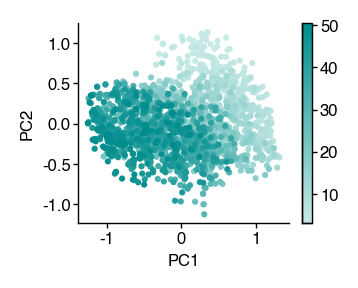

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(1.7,1.3) 
im = ax.scatter(x=pcs['PC1'], y=pcs['PC2'], 
                cmap=cmm,
                s=5,
                edgecolor='none',
                c=pcs['age'], 
               )
cb=fig.colorbar(im,ax=ax)
tick_values = [10,20,30,40,50]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])

sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [25]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_male_norm_longv2.pdf')

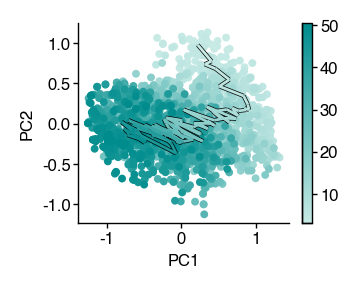

In [26]:
# Create segments for LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=1.5)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmm,
    s=8,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])
tick_values = [10,20,30,40,50]

# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [27]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_male_norm_line_longv2.pdf')

-0.6811372316215466


/tmp/ipykernel_31276/4105865259.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


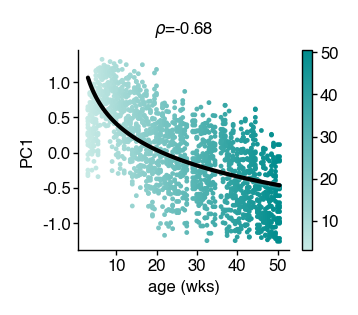

In [28]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)
fig, ax = plt.subplots()
fig.set_size_inches(1.7,1.3) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=3, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC1', xticks=[10,20,30,40,50])
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
tick_values = [10,20,30,40,50]
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

In [29]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_pc1_correlation_male_longv2.pdf')

In [30]:
## indv trajectories

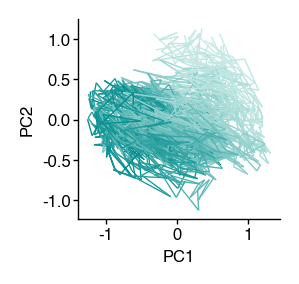

In [31]:
# Create a color map for the mice
import random
mice = pcs['mouse'].unique()
colors = sns.color_palette('husl', len(mice))
color_map = dict(zip(mice, colors))
selected_mice = random.sample(list(mice), 4)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Scatter plot with color by mouse
for mouse in mice:
#for mouse in selected_mice:
    mouse_data = pcs[pcs['mouse'] == mouse]

    # Create segments for LineCollection
    points = np.array([mouse_data['PC1'], mouse_data['PC2']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=0.5)
    lc.set_array(np.linspace(0, 1, len(mouse_data['PC1'])))

    # Create the line collection object
    #lc = LineCollection(segments, color=color_map[mouse], linewidth=0.5)
    black_lc = LineCollection(segments, colors='black', linewidth=0.5)

    # Add the black line collection to the plot
    #ax.add_collection(black_lc)

    # Add the line collection to the plot
    ax.add_collection(lc)
    ax.autoscale()

# Add legend
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.title('PCA plot with trajectories by mouse females')
plt.show()

In [32]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_indv_traj_male_longv2.pdf')

In [33]:
## joint PCA
m_data=m_norm.copy()
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data=f_norm.copy()
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])
df=data.copy()

In [34]:
pc = PCA(n_components=2)
pcss = pc.fit_transform(df)
pcs = pd.DataFrame(pcss, columns=['PC1','PC2'])
pcs['sex'] = df.index.get_level_values('sex')
pcs['age'] = df.index.get_level_values('age')

spcs = pcs.sample(frac=1).reset_index(drop=True)

In [35]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.23537297 0.34890007]


In [36]:
norm = plt.Normalize(vmin=4, vmax=90)
mask = spcs['sex'] == "m"
c = cmm(norm(spcs.loc[mask, 'age']))
spcs.loc[mask, 'color'] = [str(tuple(x)) for x in c]
mask = spcs['sex'] == "f"
c2 = cmf(norm(spcs.loc[mask, 'age']))
spcs.loc[mask, 'color'] = [str(tuple(x)) for x in c2]

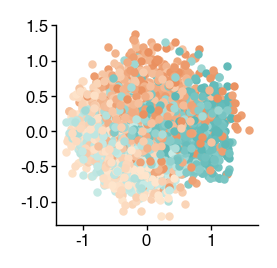

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3) 
for ind, row in spcs.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color=eval(row['color']),s=5, alpha=1)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_fvm_fit_on_both_longv2.pdf')

In [38]:
# Set display option to show all rows
pd.set_option('display.max_rows', None)
data.groupby(['age', 'sex']).size().reset_index(name='count')

,age,sex,count
0,3.0,f,20
1,3.0,m,20
2,3.5,f,20
3,3.5,m,20
4,4.0,f,20
5,4.0,m,20
6,4.5,f,20
7,4.5,m,20
8,5.0,f,20
9,5.0,m,20


## umaps

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

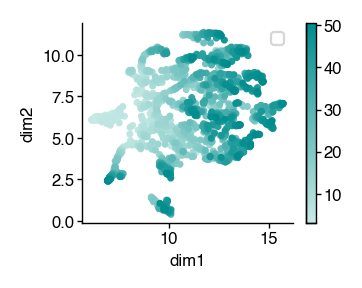

In [39]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df contains your data
# Perform UMAP dimensionality reduction
df = m_norm.copy()
reducer = umap.UMAP(random_state=0, n_neighbors=30)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap=cmm,
    s=3,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]
# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

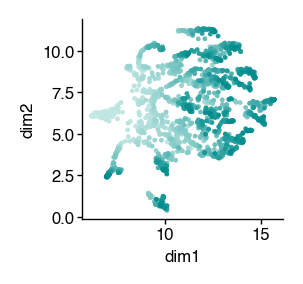

In [40]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='age',palette=cmm, legend=False, s=3, edgecolor='none')
sns.despine()

In [41]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_male_age_longv2_n30.pdf')

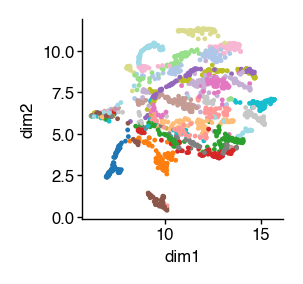

In [42]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='mouse',palette='tab20', legend=False, s=3, edgecolor='none')
#cb = fig.colorbar(im, ax=ax)
#plt.title('UMAP Plot of Data males')
sns.despine()

In [43]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_male_indv_longv2_n30.pdf')

In [44]:
## for females:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


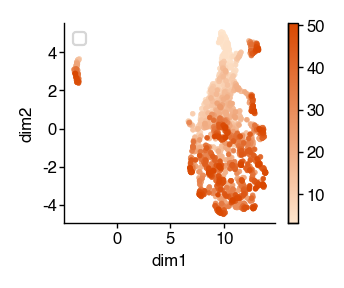

In [45]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df contains your data
# Perform UMAP dimensionality reduction
df=f_norm.copy()
reducer = umap.UMAP(random_state=0,n_neighbors=30)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')
age_pc = pcs.drop('mouse', axis=1).groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=3,
    linewidth =0.25,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]

# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data females')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

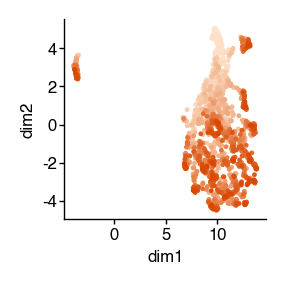

In [46]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='age',palette=cmf, legend=False, s=3, edgecolor='none')
sns.despine()

In [47]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_female_age_longv2.pdf')

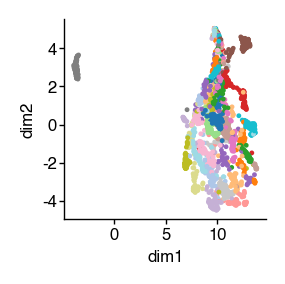

In [48]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='mouse',palette='tab20', legend=False, s=3, edgecolor='none')
#cb = fig.colorbar(im, ax=ax)
#plt.title('UMAP Plot of Data females')

sns.despine()

In [49]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_female_indv_longv2.pdf')

In [50]:
## for both sexes:
data=pd.concat([m_data,f_data])
df=data.copy()

reducer = umap.UMAP(n_neighbors=30, random_state=0)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')
pcs['sex'] = df.index.get_level_values('sex')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


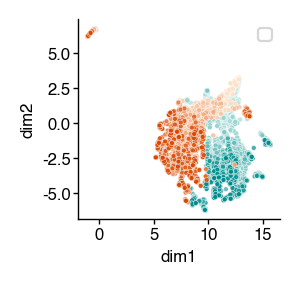

In [51]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Color the points by sex with different palettes
male_df = pcs[pcs['sex'] == 'm']
female_df = pcs[pcs['sex'] == 'f']

sns.scatterplot(data=male_df, x='dim1', y='dim2', hue='age',palette = cmm, ax=ax, legend=False,s=3)
sns.scatterplot(data=female_df, x='dim1', y='dim2',hue='age',palette = cmf, ax=ax, legend=False, s=3)

#plt.title('UMAP Plot both sexes')
plt.xlabel('dim1')
plt.ylabel('dim2')
sns.despine()
plt.legend()
plt.show()

In [52]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_fvm_age_longv2.pdf')